# Data Processing Engine

In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## Data Importing and Preliminary Cleaning

First, we use a loop to import data from the .xls files--each of which have 3 sheets. We want to focus on the factor data, i.e. "characteristics" sheet.  

In addition, we want the future returns from the "future_returns" sheet to estimated real mean returns. We will exclude market returns in our model to reduce noises as market fluctuations heavily influence assets returns. Inclusion of market returns in a previous model--not shown here--resulted in both poor fit and subsequently, poor performance.  

The asset returns excluding market returns will be fed to the "characteristics" sheet--i.e. dfChar--so we can estimate the coeficients of each factors. Recall that we hypothesized the estimated expected asset risk premium for each asset to be a linear equation as below:  

\begin{equation}
    \begin{split}
        E[R_i - R_m] =& \gamma_0 + \gamma_2 X_1 + \gamma_3 X_2 + ... \gamma_n X_{n+1} \\
                     =& \gamma_0 + \sum_{i=1}^n \gamma_i X_i  \\
        \text{where:}  \\
        \gamma_i =& \quad \text{coefficients of factors such as market cap, book-to-market ratio, etc.}  \\
    \end{split}
\end{equation}

In [2]:
import os
import glob
import numpy as np
import pandas as pd

path = os.getcwd() + '/all_data_practice/'
files = os.listdir(path)

dfRet = pd.DataFrame()
dfChar = pd.DataFrame()
dfFutRet = pd.DataFrame()

for filename in files:
    # Save data from each sheet to a df
    datRet = pd.read_excel(path+filename, sheet_name='returns')
    datChar = pd.read_excel(path+filename, sheet_name='characteristics')
    datFutRet = pd.read_excel(path+filename, sheet_name='future_returns')

    # Manipulating the 'characteristics' sheet to be legible
    datChar = datChar.T.reset_index()  # Transpose data so funds' factors end up in rows
    datChar.columns = datChar.iloc[0]  # Set name for columns to be factor name
    datChar.rename(columns={'Unnamed: 0':'fund_id'}, inplace=True)  # Set id for each fund 1,2,...
    datChar.drop(datChar.index[0], inplace=True)  # Dropping unnecessary index row due to tranpose
    
    # Manipulating the 'future_returns' sheet to be legible
    fundIDs = ["Fund 1", 
             "Fund 2", 
             "Fund 3", 
             "Fund 4", 
             "Fund 5", 
             "Fund 6", 
             "Fund 7", 
             "Fund 8", 
             "Fund 9", 
             "Fund 10"]
    # Removing RM components from RI to reduce noise
    for fundID in fundIDs:
        datFutRet[fundID] -= (datFutRet["RMRF"] + datFutRet["RF"])
    
    datFutRet = datFutRet.T.reset_index()  # Transpose data so fund id ends up in row 
    datFutRet.columns = datFutRet.iloc[0]  # Set name for columns, month ## in the case
    datFutRet.drop(datFutRet.index[[0,1,12]], inplace=True)   # drop rmrf, rf and the column index rows
    datFutRet.rename(columns={'Unnamed: 0':'fund_id'}, inplace=True)  # Set fund id
    temp = datFutRet.melt(id_vars=['fund_id'], var_name="month", value_name="RIRM")  # Melt columns into rows
    
    # Merge 'characteristics' and 'future_returns'
    datChar = datChar.merge(temp, how='left', left_on='fund_id', right_on='fund_id')
    datChar.drop(['month'], axis=1, inplace=True)
    
    dfChar = dfChar.append(datChar)  # add to the 'characteristics' master df

In [3]:
# Inspect our data. Looks good!
dfChar

,fund_id,Market capitalization,Book-to-market ratio,Past 2 to 12 month return,Past 1 month return,Past 13 to 60 month return,Stock return variance,Operating profitability,Investment,Accruals,CAPM beta,Net share issuance,RIRM
0,Fund 1,0.4,-0.4,0.56,0.006,0.25,0.05,0.025,0.175,0.0,0.0,0.11,0.0059
1,Fund 1,0.4,-0.4,0.56,0.006,0.25,0.05,0.025,0.175,0.0,0.0,0.11,-0.0194
2,Fund 1,0.4,-0.4,0.56,0.006,0.25,0.05,0.025,0.175,0.0,0.0,0.11,-0.0291
3,Fund 1,0.4,-0.4,0.56,0.006,0.25,0.05,0.025,0.175,0.0,0.0,0.11,-0.01105
4,Fund 1,0.4,-0.4,0.56,0.006,0.25,0.05,0.025,0.175,0.0,0.0,0.11,0.00425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Fund 10,1.0,-0.3,0.06,0.006,0.1,0.15,-0.075,0.075,0.0,0.5,0.06,0.011408
116,Fund 10,1.0,-0.3,0.06,0.006,0.1,0.15,-0.075,0.075,0.0,0.5,0.06,0.009063
117,Fund 10,1.0,-0.3,0.06,0.006,0.1,0.15,-0.075,0.075,0.0,0.5,0.06,0.00922
118,Fund 10,1.0,-0.3,0.06,0.006,0.1,0.15,-0.075,0.075,0.0,0.5,0.06,-0.006164


## Data Inspection  

Next we want to have a visual inspection on each factor correlated to the single-asset returns premium--RIRM.  

<AxesSubplot:xlabel='Market capitalization', ylabel='RIRM'>

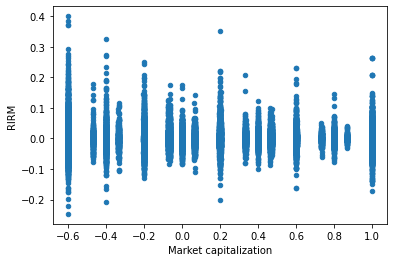

In [4]:
dfChar.plot('Market capitalization', 'RIRM', kind='scatter')

<AxesSubplot:xlabel='Book-to-market ratio', ylabel='RIRM'>

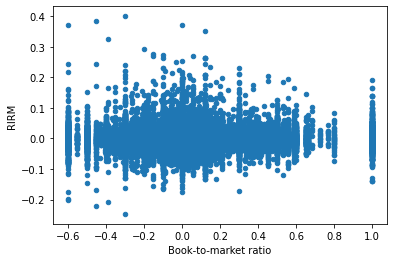

In [5]:
dfChar.plot('Book-to-market ratio', 'RIRM', kind='scatter')

<AxesSubplot:xlabel='Past 2 to 12 month return', ylabel='RIRM'>

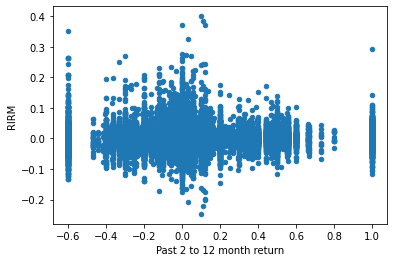

In [6]:
dfChar.plot('Past 2 to 12 month return', 'RIRM', kind='scatter')

<AxesSubplot:xlabel='Past 1 month return', ylabel='RIRM'>

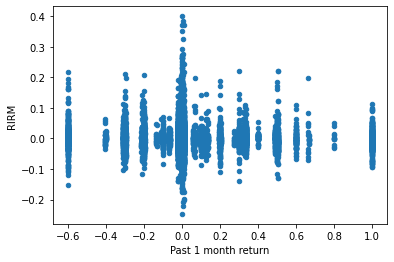

In [7]:
dfChar.plot('Past 1 month return', 'RIRM', kind='scatter')

<AxesSubplot:xlabel='Past 13 to 60 month return', ylabel='RIRM'>

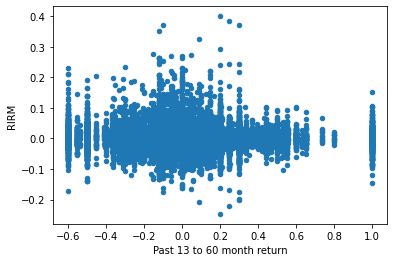

In [8]:
dfChar.plot('Past 13 to 60 month return', 'RIRM', kind='scatter')

<AxesSubplot:xlabel='Stock return variance', ylabel='RIRM'>

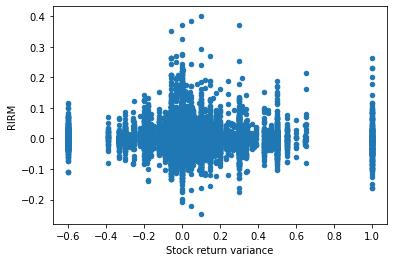

In [9]:
dfChar.plot('Stock return variance', 'RIRM', kind='scatter')

<AxesSubplot:xlabel='Operating profitability', ylabel='RIRM'>

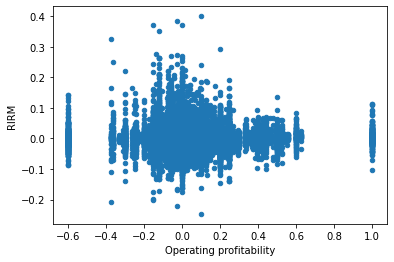

In [10]:
dfChar.plot('Operating profitability', 'RIRM', kind='scatter')

<AxesSubplot:xlabel='Investment', ylabel='RIRM'>

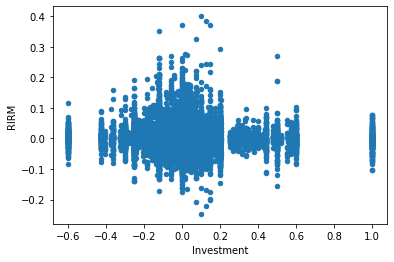

In [11]:
dfChar.plot('Investment', 'RIRM', kind='scatter')

<AxesSubplot:xlabel='Accruals', ylabel='RIRM'>

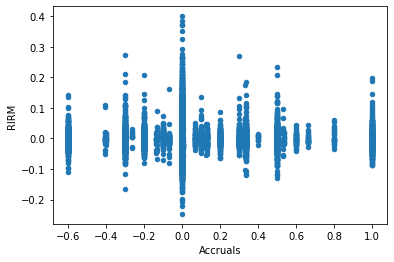

In [12]:
dfChar.plot('Accruals', 'RIRM', kind='scatter')

<AxesSubplot:xlabel='CAPM beta', ylabel='RIRM'>

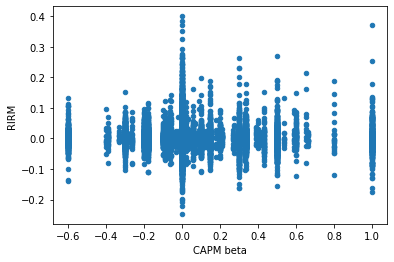

In [13]:
dfChar.plot('CAPM beta', 'RIRM', kind='scatter')

<AxesSubplot:xlabel='Net share issuance', ylabel='RIRM'>

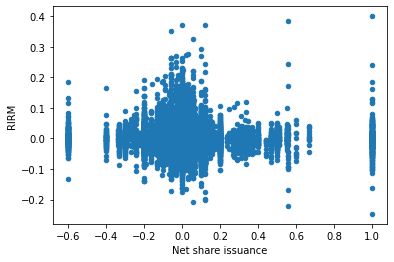

In [14]:
dfChar.plot('Net share issuance', 'RIRM', kind='scatter')

## Data Massaging & Prepping for Machine Learning  

Here, we use the Python scikit-learn ML package.  

First, we determine our numerical factors--there are 11 of them--and categorical factors--none in this case--and put them in 2 separate lists. Then we use sklearn's Pipeline--utilizing a pattern called the command patern, which take data, put them in the beginning of the pipe, then at each juncture, massaging the data into certain formats before outputing in the pipeline using Standard Scaler. The Standard Scaler takes all numerical features and set them to the same scale to prevent features' scales from dominating the model.  

The purpose is to prepare the data for machine learning.  

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, f1_score, r2_score
from sklearn.linear_model import LinearRegression

# Modeling E[R_i] based on numerical features in the list
num_cols = ['Market capitalization', 
            'Book-to-market ratio', 
            'Past 2 to 12 month return', 
            'Past 1 month return', 
            'Past 13 to 60 month return', 
            'Stock return variance', 
            'Operating profitability', 
            'Investment', 
            'Accruals', 
            'CAPM beta', 
            'Net share issuance']

cat_cols = []  # categorical features, empty in this case

# Numerical pipeline
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

# Create full pipeline: including both numeric and categorical pipeline
pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cols), 
        ('cat', OneHotEncoder(), cat_cols)
    ])

all_x_cols = num_cols + cat_cols
y_col = ['RIRM']  # this is what we are trying to predict

forest_rgr = LinearRegression()   # using linear regression

## Machine Learning on Expected Asset Returns

### Ordinary Linear Regression  

Below is a linear regression fit. The numerical method is demonstrated below:

In [16]:
# Linear Regression
forest_rgr = forest_rgr.fit(dfChar[all_x_cols], dfChar[y_col])

eReturnsCoefsOLS = forest_rgr.coef_
print(f'The coefficients of the factors are:')
eReturnsCoefsOLS

eReturnsInterceptOLS = forest_rgr.intercept_
print(f'The intercept of the factors is: {eReturnsInterceptOLS}')

# R2 metrics
train_pred = forest_rgr.predict(dfChar[all_x_cols])
print(f'R2 = {r2_score(dfChar["RIRM"], train_pred)}')

The coefficients of the factors are:


array([[-2.99164282e-04, -3.05415656e-05,  6.12886809e-03,
        -4.68012161e-03, -2.55798465e-03, -5.11186897e-03,
         1.81583266e-03, -4.38320389e-03, -1.86641086e-03,
         1.01806976e-03, -2.65130098e-03]])

The intercept of the factors is: [0.00116192]
R2 = 0.003994926510387464


### Supervised Learning  

The second method is supervised learning.. The method is to utilize known future returns premium (RIRM) an the factors in our primary factors data frame (dfChar) to fit a function to estimate expected asset risk premium.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfChar[all_x_cols], dfChar[y_col], test_size=.25)

# Train
X_train_xformed = pipeline.fit_transform(X_train)  # Take X data and squeeze it through the pipeline (do cleaning, impute, etc.)
X_test_xformed = pipeline.transform(X_test)
forest_rgr = forest_rgr.fit(X_train_xformed, y_train.values.ravel())

# Predict
print('Train Returns\n')
train_pred = forest_rgr.predict(X_train_xformed)  # predict using the original data set

print(f'R2: {r2_score(y_train.values.ravel(), train_pred)}')

print('\nTest Returns\n')  # this is what we want to predict
test_pred = forest_rgr.predict(X_test_xformed)

print(f'R2: {r2_score(y_test.values.ravel(), test_pred)}')

eReturnsInterceptSV = forest_rgr.intercept_
print(f'The intercept of the factors is: {eReturnsInterceptSV}')

eReturnsCoefsSV = forest_rgr.coef_
print(f'The coefficients of the factors are:')
eReturnsCoefsSV

# To repurpose the intercepts and coefficients in other notebooks
intercept = eReturnsInterceptOLS
coefArr = eReturnsCoefsOLS

%store intercept
%store coefArr

del intercept
del coefArr

Train Returns

R2: 0.003944886423896565

Test Returns

R2: 0.0035550004200884944
The intercept of the factors is: 0.0009325202324444444
The coefficients of the factors are:


array([-2.11048737e-04,  2.60149709e-04,  1.59348633e-03, -1.06587658e-03,
       -4.26199722e-04, -7.49624884e-04,  2.47079886e-04, -7.76388562e-04,
       -4.06820112e-04,  9.94576135e-05, -1.78067146e-04])

Stored 'intercept' (ndarray)
Stored 'coefArr' (ndarray)


## Regressed Result
We has the final Fama-MacBeth regressed coefficients and factors as below:

In [18]:
rgrFamMac = pd.DataFrame(eReturnsCoefsOLS)
rgrFamMac.columns = num_cols
rgrFamMac["Intercept"] = eReturnsInterceptOLS
rgrFamMac

,Market capitalization,Book-to-market ratio,Past 2 to 12 month return,Past 1 month return,Past 13 to 60 month return,Stock return variance,Operating profitability,Investment,Accruals,CAPM beta,Net share issuance,Intercept
0,-0.000299,-0.000031,0.006129,-0.00468,-0.002558,-0.005112,0.001816,-0.004383,-0.001866,0.001018,-0.002651,0.001162
